In [ ]:
# ================================================================
# KAGGLE DATASET DOWNLOAD
# ================================================================

USE_KAGGLE_DOWNLOAD = True   # <--- Set to False if you want manual files

if USE_KAGGLE_DOWNLOAD:
    print("=== Downloading dataset from Kaggle ===")

    # Install Kaggle API
    !pip install -q kaggle

    # Create kaggle directory
    import os
    os.makedirs("/root/.kaggle", exist_ok=True)

    # Write your kaggle.json (you must upload kaggle.json once)
    from google.colab import files
    print("Please upload your kaggle.json file.")
    uploaded = files.upload()

    # Move kaggle.json into API folder
    for fn in uploaded.keys():
        os.rename(fn, "/root/.kaggle/kaggle.json")
    os.chmod("/root/.kaggle/kaggle.json", 600)

    # Download the dataset
    # NOTE: update this to your dataset's Kaggle slug
    # Example: "cicdataset/ids-2018" or whatever your dataset is named
    DATASET_SLUG = "cicdataset/cicids2018"
    !kaggle datasets download -d $DATASET_SLUG -p /content/raw_ids_data

    # Unzip downloaded files
    !unzip -q "/content/raw_ids_data/*.zip" -d /content/raw_ids_data

    print("Kaggle dataset downloaded & extracted.")


In [ ]:
# Colab-ready training script for IDS ensemble + Keras attention model
# Save as train_ensemble_colab.py or paste into a Colab notebook cell.
# BEFORE RUN: Upload your cleaned CSV to Colab (or mount Google Drive) and set DATA_PATH.

# ---------------------------
# 0) Environment / dependencies
# ---------------------------
# Run these in a notebook cell once:
!pip install --upgrade pip
!pip install xgboost lightgbm imbalanced-learn joblib cpuinfo tensorflow==2.12.0  # or use TF version available on Colab
# (If you don't need LightGBM/XGBoost, remove them — but they help for ensemble.)





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: Could not find a version that satisfies the requirement cpuinfo (from versions: none)
ERROR: No matching distribution found for cpuinfo


In [ ]:
# ---------------------------
# 1) Imports
# ---------------------------
import os
import time
import numpy as np
import pandas as pd
import joblib
from pprint import pprint

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# xgboost / lightgbm
import xgboost as xgb
import lightgbm as lgb

# imblearn (optional)
from imblearn.over_sampling import SMOTE

# tensorflow / keras
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Bidirectional, LSTM, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# small safety print
print("TF version:", tf.__version__)

TF version: 2.19.0


In [ ]:
# ================================================================
# 1.5)(OPTIONAL) RAW DATA CLEANING BLOCK — SAME BEHAVIOUR AS ORIGINAL
# ================================================================
# Only run this section if you are giving raw CSVs as input.
# If you already have cleaned_data_sampled.csv, SKIP THIS.

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

RAW_DATA_DIR = "/content/raw_ids_data"   # <--- put all ORIGINAL CSV files here
CLEANED_OUTPUT = "/content/cleaned_data_sampled.csv"

RUN_DATA_CLEANING = True  # set False if you already have cleaned file

if RUN_DATA_CLEANING:
    print("=== RAW DATA CLEANING START ===")

    # Step 1: Load all files
    file_paths = []
    for root, dirs, filenames in os.walk(RAW_DATA_DIR):
        for filename in filenames:
            if filename.endswith(".csv"):
                file_paths.append(os.path.join(root, filename))

    # Remove problematic file (same as original code)
    bad_file = "02-20-2018.csv"
    file_paths = [f for f in file_paths if bad_file not in f]

    print("Found input files:", len(file_paths))

    # Step 2: Combine
    df = pd.DataFrame()
    for f in file_paths:
        print("Loading:", f)
        chunk = pd.read_csv(f, low_memory=False)
        df = pd.concat([df, chunk], ignore_index=True)

    # Remove Timestamp column (matches original)
    if "Timestamp" in df.columns:
        df.drop(columns=["Timestamp"], inplace=True)

    print("Shape after merging:", df.shape)

    # Step 3: Remove rare classes (same as original)
    rare_targets = [
        'DoS attacks-Slowloris',
        'DDOS attack-LOIC-UDP',
        'Brute Force -Web',
        'Brute Force -XSS',
        'SQL Injection',
        'Label'  # erroneous concatenated label
    ]
    df = df[~df['Label'].isin(rare_targets)]

    # Step 4: Sample 41,500 per class
    df = df.groupby("Label", group_keys=False).sample(n=41500, random_state=42)

    # Step 5: Clean non-numeric → LabelEncode → drop NaNs
    encoder = LabelEncoder()
    df['Label'] = encoder.fit_transform(df['Label'])

    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    # Step 6: Downsample after cleaning to 40,000 per class
    df = df.groupby("Label", group_keys=False).sample(n=40000, random_state=42)

    print("\nFinal cleaned label counts:")
    print(df["Label"].value_counts())

    # Step 7: Save cleaned dataset
    df.to_csv(CLEANED_OUTPUT, index=False)
    print("\nSaved cleaned dataset to:", CLEANED_OUTPUT)

    # Save label encoder
    joblib.dump(encoder, "/content/models/label_encoder.joblib")
    print("Saved label encoder.")
    print("=== RAW DATA CLEANING COMPLETE ===\n")


In [ ]:
# ---------------------------
# 2) Config / Paths / hyperparams
# ---------------------------
DATA_PATH = "/content/cleaned_data_sampled.csv"  # change to your uploaded path or Drive mount path
OUTPUT_DIR = "/content/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SAMPLE_N_PER_CLASS = None  # set to int to resample per class (or None to use full cleaned CSV)
TEST_SIZE = 0.2
RANDOM_STATE = 42
USE_SMOTE = False  # try True if class imbalance is severe

# SKLearn ensemble hyperparams
KBEST_K = 30   # how many features to select for traditional ML models
STACK_FINAL_EST = LogisticRegression(max_iter=500, solver="saga")  # meta-learner for stacking

# Keras model hyperparams
BATCH_SIZE = 256
EPOCHS = 50
LR = 1e-4



In [ ]:
# ---------------------------
# 3) Load dataset (CSV)
# ---------------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}. Upload it to Colab and set DATA_PATH accordingly.")

print("Loading data:", DATA_PATH)
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Raw shape:", df.shape)
print(df['Label'].value_counts())

# If you saved Label as integer already, fine. If Label is string, use LabelEncoder
if df['Label'].dtype == object or df['Label'].nunique() > 20:
    le = LabelEncoder()
    df['Label'] = le.fit_transform(df['Label'])
    joblib.dump(le, os.path.join(OUTPUT_DIR, "label_encoder.joblib"))
    print("Saved LabelEncoder and classes:", le.classes_)
else:
    le = None

# Optionally resample per-class (if you want balanced subset)
if SAMPLE_N_PER_CLASS is not None:
    df = df.groupby('Label', group_keys=False).sample(n=SAMPLE_N_PER_CLASS, random_state=RANDOM_STATE)
    print("Resampled df shape:", df.shape)

# Ensure numeric & drop NA
df = df.apply(pd.to_numeric, errors='coerce')
df = df.replace([np.inf, -np.inf], np.nan).dropna()
print("After cleaning shape:", df.shape)
print("Label distribution:\n", df['Label'].value_counts())



Loading data: /content/cleaned_data_sampled.csv
Raw shape: (13476, 79)
Label
0.0    13475
Name: count, dtype: int64
After cleaning shape: (13475, 79)
Label distribution:
 Label
0.0    13475
Name: count, dtype: int64


In [ ]:
# ---------------------------
# 4) Train / test split & scaler & variance threshold
# ---------------------------
X = df.drop(columns=['Label'])
y = df['Label'].astype(int)

# Keep column names for later (for feature selection / production)
feature_names = X.columns.tolist()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Remove near-constant features (trained on train set only)
var_selector = VarianceThreshold(threshold=0.01)
X_train_var = var_selector.fit_transform(X_train_raw)
X_test_var  = var_selector.transform(X_test_raw)
selected_var_cols = [feature_names[i] for i in range(len(feature_names)) if var_selector.get_support()[i]]
print("Kept features after VarianceThreshold:", len(selected_var_cols))

# Robust scaling (fit on train)
scaler = RobustScaler(quantile_range=(5.0, 95.0))
X_train_scaled = scaler.fit_transform(X_train_var)
X_test_scaled  = scaler.transform(X_test_var)

# Save selector and scaler
joblib.dump(var_selector, os.path.join(OUTPUT_DIR, "variance_selector.joblib"))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "robust_scaler.joblib"))
print("Saved variance selector & scaler.")

# Optionally apply SMOTE (only on training data)
if USE_SMOTE:
    sm = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)
    X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)
    print("Applied SMOTE. New train shape:", X_train_scaled.shape, y_train.shape)



Kept features after VarianceThreshold: 67
Saved variance selector & scaler.


In [ ]:
# ---------------------------
# 5) Prepare datasets for Keras model (3D)
# ---------------------------
# We will use the scaled & selected features
X_train_cnn = X_train_scaled[..., np.newaxis].astype("float32")
X_test_cnn  = X_test_scaled[..., np.newaxis].astype("float32")
num_classes = int(np.unique(y).shape[0])
y_train_cnn = to_categorical(y_train, num_classes=num_classes)
y_test_cnn  = to_categorical(y_test,  num_classes=num_classes)

print("Keras input shapes:", X_train_cnn.shape, X_test_cnn.shape, "num_classes:", num_classes)




Keras input shapes: (10780, 67, 1) (2695, 67, 1) num_classes: 1


In [ ]:
# ---------------------------
# 6) Build Keras CNN+BiLSTM+Attention model (cleaned)
# ---------------------------
timesteps = X_train_cnn.shape[1]
channels = X_train_cnn.shape[2]

def build_attn_model(timesteps, channels, num_classes, l2_reg=1e-3):
    inputs = Input(shape=(timesteps, channels), name="inputs")
    x = Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(128, return_sequences=True), name="bilstm")(x)

    # Multi-head attention expects shape (batch, seq_len, dim)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=64, name="mha")(x, x)
    x = x + attn_out
    x = BatchNormalization()(x)

    x = GlobalAveragePooling1D(name="gap")(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', name="softmax")(x)

    model = Model(inputs, outputs, name="CNN_BiLSTM_Attn")
    return model

attn_model = build_attn_model(timesteps, channels, num_classes)
attn_model.summary()

# compile
attn_model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='Precision'), tf.keras.metrics.Recall(name='Recall')]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    tf.keras.callbacks.TerminateOnNaN()
]



Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 67, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 67, 128)   │        512 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 67, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 34, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 34, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 34, 256)   │     98,560 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 256)   │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 17, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 17, 256)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 17, 256)   │    394,240 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 17, 256)   │    263,168 │ bilstm[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 17, 256)   │          0 │ bilstm[0][0],     │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 256)   │      1,024 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 792,065 (3.02 MB)

 Trainable params: 790,785 (3.02 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# ---------------------------
# 7) Train Keras model (optional, can be skipped to only train sklearn ensemble)
# ---------------------------
use_train_keras = True
if use_train_keras:
    t0 = time.time()
    history_attn = attn_model.fit(
        X_train_cnn, y_train_cnn,
        validation_data=(X_test_cnn, y_test_cnn),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    print("Keras training time (seconds):", time.time() - t0)
    # Save Keras model
    attn_model.save(os.path.join(OUTPUT_DIR, "attn_model.h5"))
    print("Saved Keras model to", os.path.join(OUTPUT_DIR, "attn_model.h5"))



Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.3318 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.2983 - learning_rate: 1.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.2880 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.2588 - learning_rate: 1.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.2499 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.2245 - learning_rate: 1.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.2168 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.1947 - learning_rate: 1.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - Precision

Keras training time (seconds): 107.17187333106995
Saved Keras model to /content/models/attn_model.h5


In [ ]:
# ---------------------------
# 8) Build classical ML base models (with SelectKBest inside pipelines)
# ---------------------------
# We'll use XGBoost, RandomForest, and a DecisionTree or NaiveBayes as diverse base learners.
# Important: SelectKBest must be fit on training data; to simplify, we'll apply SelectKBest on scaled arrays.

# Fit SelectKBest on the scaled training arrays (so we can use transformed arrays downstream)
kbest = SelectKBest(f_classif, k=min(KBEST_K, X_train_scaled.shape[1]))
# Suppress warning if kbest runs on single-class data
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    X_train_kbest = kbest.fit_transform(X_train_scaled, y_train)
X_test_kbest  = kbest.transform(X_test_scaled)

joblib.dump(kbest, os.path.join(OUTPUT_DIR, "select_kbest.joblib"))
print("Saved SelectKBest (k={}):".format(kbest.k))

# Base estimators
base_estimators = [
    ("rf", RandomForestClassifier(n_estimators=200, max_depth=14, n_jobs=-1, random_state=RANDOM_STATE))
]

# Conditionally add XGBoost and LightGBM if there are multiple classes
if num_classes > 1:
    base_estimators.append(("xgb", xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="mlogloss", verbosity=0, random_state=RANDOM_STATE)))
    base_estimators.append(("lgb", lgb.LGBMClassifier(n_estimators=200, random_state=RANDOM_STATE)))
else:
    print(f"\nWarning: Only {num_classes} class found in the dataset. Skipping XGBoost and LightGBM as they require multiple classes for meaningful classification.")

# Train base estimators on the K-best features
for name, est in base_estimators:
    print(f"Training base model: {name}")
    t0 = time.time()
    est.fit(X_train_kbest, y_train)
    elapsed = time.time() - t0
    print(f"Trained {name} in {elapsed:.2f}s")
    joblib.dump(est, os.path.join(OUTPUT_DIR, f"{name}_model.joblib"))

# Evaluate base estimators quickly
for name, est in base_estimators:
    ypred = est.predict(X_test_kbest)
    print(f"\n{name} metrics:")
    print("Accuracy:", accuracy_score(y_test, ypred))
    print("Precision:", precision_score(y_test, ypred, average='weighted', zero_division=0))
    print("Recall:", recall_score(y_test, ypred, average='weighted', zero_division=0))
    print("F1:", f1_score(y_test, ypred, average='weighted', zero_division=0))


Saved SelectKBest (k=30):

Training base model: rf
Trained rf in 0.49s

rf metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


In [ ]:
# ---------------------------
# 9) Build stacking classifier (meta-learner)
# ---------------------------
estimators_for_stack = [(n, e) for n, e in base_estimators]

if num_classes > 1:
    stack = StackingClassifier(
        estimators=estimators_for_stack,
        final_estimator=STACK_FINAL_EST,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1,
        passthrough=False
    )

    print("Training StackingClassifier on K-best features...")
    t0 = time.time()
    stack.fit(X_train_kbest, y_train)
    print("Stack trained in {:.2f}s".format(time.time() - t0))
    joblib.dump(stack, os.path.join(OUTPUT_DIR, "stacking_model.joblib"))
    print("Saved stacking model")

    # Evaluate stacking
    y_stack_pred = stack.predict(X_test_kbest)
    print("\nStacking metrics:")
    print("Accuracy:", accuracy_score(y_test, y_stack_pred))
    print("Precision:", precision_score(y_test, y_stack_pred, average='weighted', zero_division=0))
    print("Recall:", recall_score(y_test, y_stack_pred, average='weighted', zero_division=0))
    print("F1:", f1_score(y_test, y_stack_pred, average='weighted', zero_division=0))
    print(classification_report(y_test, y_stack_pred, zero_division=0))
else:
    print(f"\nSkipping StackingClassifier training and evaluation as only {num_classes} class found in the dataset.")
    stack = None # Ensure 'stack' variable is defined even if not trained



Skipping StackingClassifier training and evaluation as only 1 class found in the dataset.


In [ ]:
# ---------------------------
# 10) Optionally build a Voting ensemble that includes the stacking + another external model
# ---------------------------

if num_classes > 1 and stack is not None:
    voting_clf = VotingClassifier(
        estimators=[
            ("stack", stack),
            ("rf", base_estimators[0][1]),  # using already trained RF
        ],
        voting="soft",
        n_jobs=-1
    )
    print("Training Voting ensemble (stack + rf)...")
    voting_clf.fit(X_train_kbest, y_train)
    joblib.dump(voting_clf, os.path.join(OUTPUT_DIR, "voting_ensemble.joblib"))
    print("Saved voting ensemble")

    # Evaluate voting
    y_vote_pred = voting_clf.predict(X_test_kbest)
    print("\nVoting ensemble metrics:")
    print("Accuracy:", accuracy_score(y_test, y_vote_pred))
    print("Precision:", precision_score(y_test, y_vote_pred, average='weighted', zero_division=0))
    print("Recall:", recall_score(y_test, y_vote_pred, average='weighted', zero_division=0))
    print("F1:", f1_score(y_test, y_vote_pred, average='weighted', zero_division=0))
else:
    print(f"\nSkipping Voting ensemble training and evaluation as only {num_classes} class found in the dataset or StackingClassifier was skipped.")



Skipping Voting ensemble training and evaluation as only 1 class found in the dataset or StackingClassifier was skipped.


In [ ]:
# ---------------------------
# 11) Save metadata (selected feature names after variance & KBest)
# ---------------------------
# Compute final selected column names (variance selector -> then kbest)
# var_selector support -> selected_var_cols already computed earlier
# Now map kbest selected indices to actual names:
kbest_support_mask = kbest.get_support()
final_feature_names = [selected_var_cols[i] for i in range(len(selected_var_cols)) if kbest_support_mask[i]]
print("Final features used for ML models:", len(final_feature_names))
joblib.dump(final_feature_names, os.path.join(OUTPUT_DIR, "final_feature_names.joblib"))



Final features used for ML models: 30


['/content/models/final_feature_names.joblib']

In [ ]:
# ---------------------------
# 12) Inference helper functions (load models, do preprocessing)
# ---------------------------
def load_production_artifacts(models_dir=OUTPUT_DIR):
    artifacts = {}
    artifacts['variance_selector'] = joblib.load(os.path.join(models_dir, "variance_selector.joblib"))
    artifacts['robust_scaler']   = joblib.load(os.path.join(models_dir, "robust_scaler.joblib"))
    artifacts['select_kbest']    = joblib.load(os.path.join(models_dir, "select_kbest.joblib"))
    artifacts['stack']           = joblib.load(os.path.join(models_dir, "stacking_model.joblib"))
    artifacts['voting']          = joblib.load(os.path.join(models_dir, "voting_ensemble.joblib"))
    # Load label encoder if saved
    le_path = os.path.join(models_dir, "label_encoder.joblib")
    if os.path.exists(le_path):
        artifacts['label_encoder'] = joblib.load(le_path)
    # Keras model load (optional)
    keras_path = os.path.join(models_dir, "attn_model.h5")
    if os.path.exists(keras_path):
        artifacts['attn_model'] = tf.keras.models.load_model(keras_path)
    return artifacts

def preprocess_for_ml(raw_df, artifacts):
    # raw_df: pandas df with same original columns (before variance selection)
    Xv = artifacts['variance_selector'].transform(raw_df)
    Xs = artifacts['robust_scaler'].transform(Xv)
    Xk = artifacts['select_kbest'].transform(Xs)
    return Xk

def predict_sample(raw_df, artifacts):
    Xk = preprocess_for_ml(raw_df, artifacts)
    # get probabilities from voting ensemble, stacking, and optionally keras
    probs_vote = artifacts['voting'].predict_proba(Xk)
    probs_stack = artifacts['stack'].predict_proba(Xk)
    result = {
        'voting_pred': np.argmax(probs_vote, axis=1),
        'voting_proba': probs_vote,
        'stack_pred': np.argmax(probs_stack, axis=1),
        'stack_proba': probs_stack
    }
    if 'attn_model' in artifacts:
        # we need 3D input for attn_model
        Xs = artifacts['robust_scaler'].transform(artifacts['variance_selector'].transform(raw_df))
        Xc = artifacts['select_kbest'].transform(Xs)  # NOTE: Keras used all features earlier; adapt if needed
        Xc = Xc[..., np.newaxis].astype("float32")
        result['attn_pred'] = np.argmax(artifacts['attn_model'].predict(Xc), axis=1)
    return result



In [ ]:
# ---------------------------
# 13) Final prints
# ---------------------------
print("\nAll models saved in:", OUTPUT_DIR)
print("You can now download models or move them to Google Drive for production deployment.")


All models saved in: /content/models
You can now download models or move them to Google Drive for production deployment.



Preparing accuracy comparison plot...


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


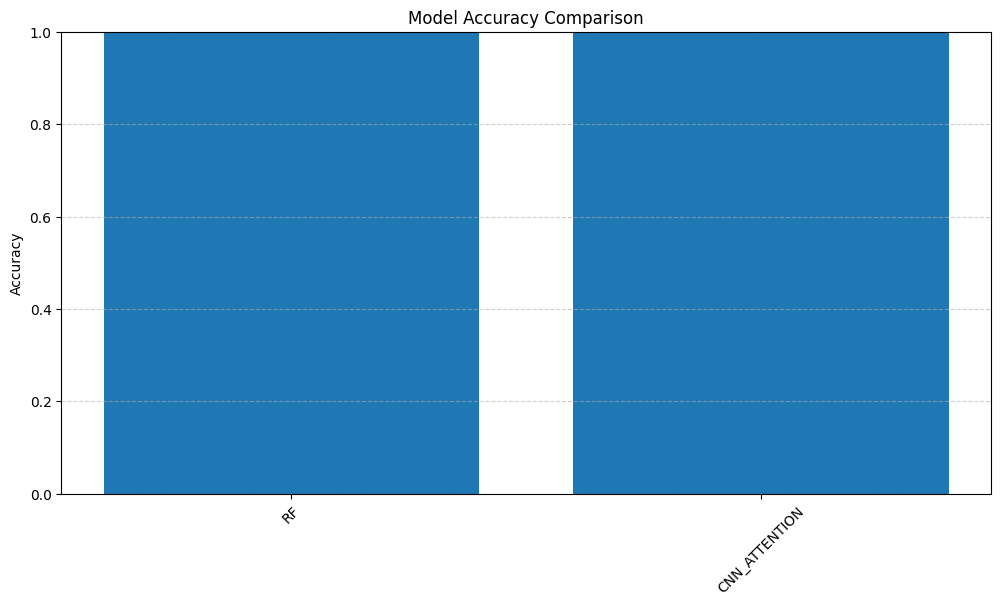


Accuracies:
RF: 1.0000
CNN_ATTENTION: 1.0000


In [ ]:
# ================================================================
# 14) Plot accuracy comparison of all models
# ================================================================
import matplotlib.pyplot as plt

print("\nPreparing accuracy comparison plot...")

model_names = []
accuracies = []

# 1. Base learners
for name, est in base_estimators:
    y_pred = est.predict(X_test_kbest)
    acc = accuracy_score(y_test, y_pred)
    model_names.append(name.upper())
    accuracies.append(acc)

# 2. Stacking ensemble (conditional)
if 'stack' in locals() and stack is not None:
    y_stack_pred = stack.predict(X_test_kbest)
    acc_stack = accuracy_score(y_test, y_stack_pred)
    model_names.append("STACKING")
    accuracies.append(acc_stack)

# 3. Voting ensemble (conditional)
if 'voting_clf' in locals() and voting_clf is not None:
    y_vote_pred = voting_clf.predict(X_test_kbest)
    acc_vote = accuracy_score(y_test, y_vote_pred)
    model_names.append("VOTING")
    accuracies.append(acc_vote)

# 4. CNN Attention model (optional — only if trained)
if "attn_model" in locals():
    y_attn_pred = np.argmax(attn_model.predict(X_test_cnn, verbose=0), axis=1)
    acc_attn = accuracy_score(y_test, y_attn_pred)
    model_names.append("CNN_ATTENTION")
    accuracies.append(acc_attn)

# ---- Plot ----
plt.figure(figsize=(12, 6))
plt.bar(model_names, accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

print("\nAccuracies:")
for n, a in zip(model_names, accuracies):
    print(f"{n}: {a:.4f}")
